In [2]:
import numpy as np
import pandas as pd  # pandas库
from imblearn.over_sampling import SMOTE  # 过抽样处理库SMOTE
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, \
    RandomForestClassifier  # 四种集成分类库和投票方法库
from sklearn.model_selection import StratifiedKFold, cross_val_score  # 导入交叉检验算法
from sklearn.preprocessing import OrdinalEncoder  # 字符串转数值
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 
# 解决中文乱码
plt.rcParams['font.sans-serif']=['simHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
raw_data = pd.read_table('abnormal_orders.txt', delimiter=',')  # 读取数据集
print(raw_data.shape)
raw_data.head(5)

(134190, 14)


,order_id,order_date,order_time,cat,attribution,pro_id,pro_brand,total_money,total_quantity,order_source,pay_type,user_id,city,abnormal_label
0,4277880103,2013-10-17,13:09:16,NaN,GO,8000001215,NaN,1000.0,1000,游戏站点,当当支付,murongchun,北京市,0
1,4283851335,2013-09-23,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
2,4277700101,2013-08-27,14:26:38,NaN,GO,7000000960,国之美艺术品,8000.0,160,do.site_id,在线支付,1391175862,NaN,1
3,4276537082,2013-09-11,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
4,4281111595,2013-04-10,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1


In [4]:
#将变量名改为中文
df = raw_data.copy()
df.rename(columns={'order_id':'订单ID', "order_date":"订单日期", "order_time":"订单时间", 
                   "cat":"商品类别", "attribution":"渠道来源", "pro_id":"商品ID",
                   "pro_brand":"商品品牌", "total_money":"销售金额", "total_quantity":"销售数量",
                  "order_source":"订单来源","pay_type":"支付类型", "user_id":"用户ID","city":"订单城市",
                   "abnormal_label":"异常订单"}, inplace = True)
df.head(1)

,订单ID,订单日期,订单时间,商品类别,渠道来源,商品ID,商品品牌,销售金额,销售数量,订单来源,支付类型,用户ID,订单城市,异常订单
0,4277880103,2013-10-17,13:09:16,NaN,GO,8000001215,NaN,1000.0,1000,游戏站点,当当支付,murongchun,北京市,0


In [5]:
df.info()
# 数据里面包含了 3 列特殊字段: 订单ID、商品ID、用户ID。订单ID作为每个订单的唯一记录，在特征中的所有记录中都是唯一值，因此没有实际意义，之后会去掉。
# 而商品ID和用户ID作为商品和用户的唯一识别标志，可以有一定的参考价值，因此后续会保留。 

# 本实验中应用了商品ID和用户ID，这两类ID一般作为关联主键或者数据去重唯一ID，而很少用于模型训练本身。
# 这里使用的原因是希望能从中找到是否异常订单也会集中在某些品类或某些用户上。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134190 entries, 0 to 134189
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   订单ID    134190 non-null  int64  
 1   订单日期    134190 non-null  object 
 2   订单时间    134190 non-null  object 
 3   商品类别    132800 non-null  object 
 4   渠道来源    134190 non-null  object 
 5   商品ID    134190 non-null  int64  
 6   商品品牌    133418 non-null  object 
 7   销售金额    134189 non-null  float64
 8   销售数量    134190 non-null  int64  
 9   订单来源    134190 non-null  object 
 10  支付类型    134190 non-null  object 
 11  用户ID    134190 non-null  object 
 12  订单城市    134188 non-null  object 
 13  异常订单    134190 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 14.3+ MB


In [6]:
# 析到在商品类别、商品品牌、销售金额和订单城市上有缺失值，下面我们查看有缺失的行总记录数。
print('Total number of NA lines is: {0} ' .
      format(df.isnull().any(axis=1).sum()))
# 可得到总的缺失记录为1429，占总样本量的1%左右，因此，后续可以考虑丢弃。
# 注：对于缺失值选择填充、丢弃甚至不处理，没有固定的标准。一般而言，如果后续模型支持 Nan 值(例如使用 XGBoost)，一般选择不处理；
# 如果 NA 值记录的比例小，一般选择放弃或填充都可以；如果 NA 值的比例大，一般需要填充处理。

Total number of NA lines is: 1429 


In [7]:
# 订单ID作为每个订单的唯一记录，在特征中的所有记录中都是唯一值，因此没有实际意义
# 丢弃订单ID列
drop_id_set = df.drop(['订单ID'],axis=1)
# 含Nan值的行进行删除。
# Nan处理
drop_na_set = drop_id_set.dropna()  # 丢弃

In [8]:
drop_na_set.describe().round(3)
# 由结果可见，销售金额和销售数量中存在了极大值，但是选择不做任何处理，因为本实验主题就是针对异常值的分类检测。

,商品ID,销售金额,销售数量,异常订单
count,1.327610e+05,132761.000,132761.000,132761.000
mean,3.366905e+09,666.437,1.187,0.213
std,3.281610e+09,2915.885,1.675,0.409
min,1.000000e+09,0.500,1.000,0.000
25%,1.000321e+09,29.000,1.000,0.000
50%,1.000369e+09,99.000,1.000,0.000
75%,8.001639e+09,385.000,1.000,0.000
max,8.002352e+09,766000.000,200.000,1.000


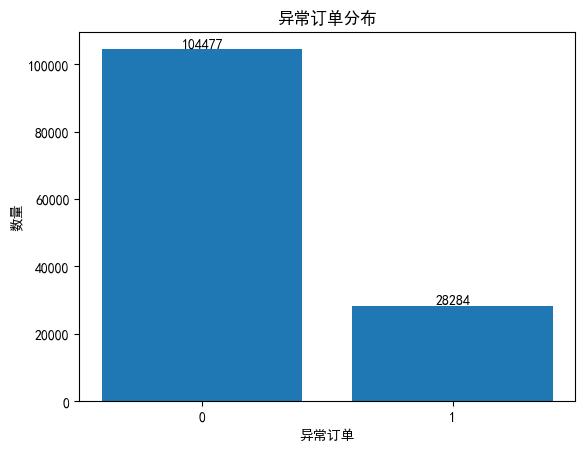

In [9]:
# label是“异常订单”，有两个类别：0和1，通过画条形图进行样本均衡审查。
# 样本均衡审查
# 统计不同值的数量
value_counts = drop_na_set['异常订单'].value_counts()

# 创建条形图
plt.bar(value_counts.index, value_counts.values)
# 在条形图上显示数量
for i, v in enumerate(value_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)
# 设置标签和标题
plt.xticks(value_counts.index)
plt.xlabel('异常订单')
plt.ylabel('数量')
plt.title('异常订单分布')
# 显示图形
plt.show()

In [10]:
# 样本均衡审查
print('{:*^60}'.format('Labesl samples count:'))
print(drop_na_set.iloc[:, -1].value_counts()) #-1索引为最后一列
# 结果显示了正样本（1）的比例只有负样本（0）的 35%左右，后续需要做样本均衡处理。
# 注：由于本实验中的两类数据差异并没有特别大（例如 1:10甚至更大），因此均衡处理不是必需的。但实际上，异常检测在很多情况下的记录是比较少的，因此样本均衡操作通常必不可少。
# 常见的样本均衡方法包括：
# 1. 欠采样（Undersampling）： 从数量较多的类别中随机删除一些样本，以减少样本数量差异。这可能会降低信息损失，但也可能会丢失重要信息。
# 2. 过采样（Oversampling）： 复制数量较少的样本或生成类似的样本，以增加少数类别的样本数量。这可能会导致过拟合，但可以减少样本不均衡带来的问题。
# 3. 生成合成样本（Synthetic Sample Generation）： 使用生成模型（如SMOTE）来生成合成的少数类别样本，以增加样本数量。
# 4. 权重调整（Weighting）： 在算法中为不同类别的样本赋予不同的权重，使模型更关注数量较少的类别。
# 5. 集成方法（Ensemble Methods）： 使用集成算法，如集成学习或基于集成的分类器，以处理样本不均衡问题。
# 在进行样本均衡调整时，需要小心平衡提高性能和防止过拟合之间的关系。最佳的方法可能因数据集和问题而异，因此在应用样本均衡技术之前，建议先进行详细的数据分析和实验评估。

*******************Labesl samples count:********************
0    104477
1     28284
Name: 异常订单, dtype: int64


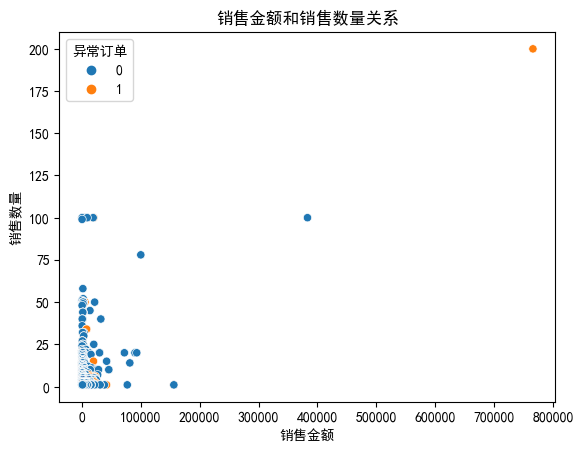

In [11]:
# 由前面描述性统计观察到，销售金额和销售数量中存在了极大值，下面我们通过散点图观察它们是否存在关系，用颜色代表是否为异常订单。
# 绘制散点图显示销售金额和销售数量之间的关系
sns.scatterplot(data=drop_na_set, x='销售金额', y='销售数量', hue='异常订单')
# 设置标签和标题
plt.xlabel('销售金额')
plt.ylabel('销售数量')
plt.title('销售金额和销售数量关系')

# 显示图形
plt.show()
# 样本量太多，且受到离群点的影响，大多聚集在一处，我们很难观察到这三者之间的关系。

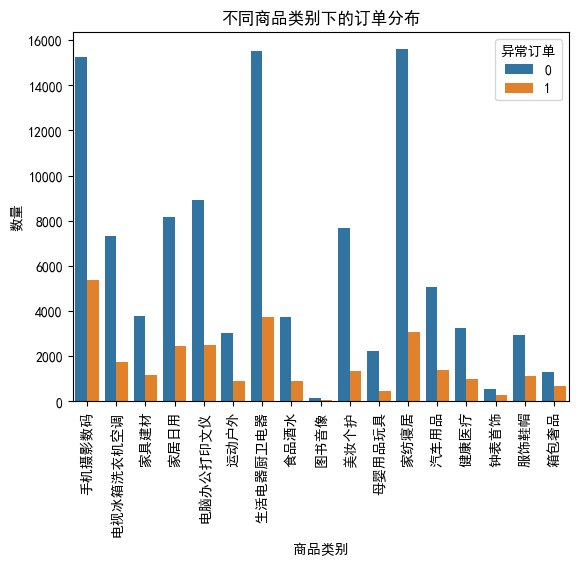

In [12]:
# 可视化分类变量商品类别和渠道来源的频率分布。
# 绘制类别分布图，显示不同商品类别下异常订单和正常订单的数量

#sns.countplot() 是 Seaborn 库中的一个函数，用于绘制分类变量的频次条形图。
# 它的主要用途是可视化数据集中每个分类变量的计数或频次分布，以便更好地理解数据的分布特征。
sns.countplot(data=drop_na_set, x='商品类别', hue='异常订单')

# 设置标签和标题
plt.xlabel('商品类别')
plt.ylabel('数量')
plt.title('不同商品类别下的订单分布')

# 显示图形
plt.xticks(rotation=90)
plt.legend(title='异常订单')
plt.show()
# 样本中，手机摄影数码、生活电器厨卫电器和家纺寝居商品类别较多；
# 另一方面，家纺寝居的异常订单占比最小，而一些品类接近三分之一。

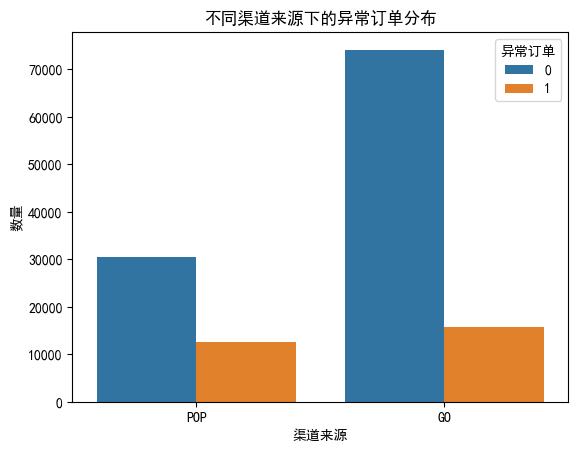

In [13]:
# 绘制渠道来源与异常订单分布的簇状柱状图
sns.countplot(data=drop_na_set, x='渠道来源', hue='异常订单')

# 设置标签和标题
plt.xlabel('渠道来源')
plt.ylabel('数量')
plt.title('不同渠道来源下的异常订单分布')

# 显示图形
# plt.xticks(rotation=90)
plt.legend(title='异常订单')
plt.show()

异常订单      0      1
渠道来源              
GO    74074  15707
POP   30403  12577 <class 'pandas.core.frame.DataFrame'>


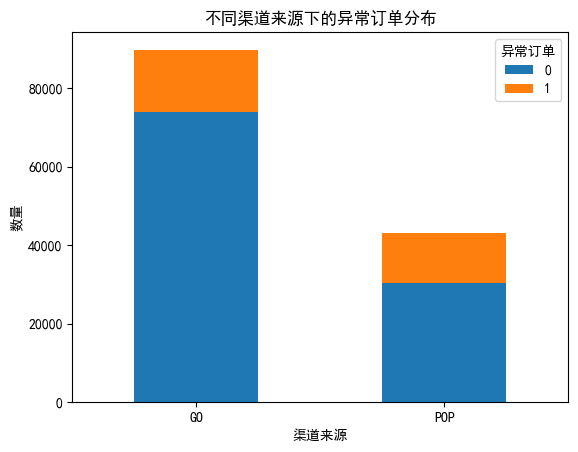

In [14]:
# 根据渠道来源和异常订单创建一个透视表
# 透视表（Pivot Table）是一种数据分析工具，用于在电子表格或数据库中对数据进行汇总、交叉分析和总结。
# 透视表可以帮助你快速了解数据的结构、模式和关系，使复杂的数据集更易于理解和分析。
pivot_table = drop_na_set.pivot_table(index='渠道来源', columns='异常订单', values='订单日期', aggfunc='count', fill_value=0)

# index='渠道来源'：这表示在数据透视表中将 '渠道来源' 列作为行索引。
# columns='异常订单'：这表示在数据透视表中将 '异常订单' 列作为列。
# values='订单日期'：这表示在数据透视表中使用 '订单日期' 列中的值进行计算。
# aggfunc='count'：这表示使用计数（count）作为聚合函数，即对每个组合进行计数。
# fill_value=0：这表示在数据透视表中用 0 填充缺失的值。
# 这个数据透视表显示每个渠道来源下有多少个正常订单和异常订单，用于更清晰地了解异常订单的分布情况。
print(pivot_table,type(pivot_table))
# 绘制堆叠柱状图
# DataFrame.plot() 是 pandas 库提供的一个用于快速绘制数据可视化图表的方法。这个方法是基于 Matplotlib 库构建的，因此可以轻松地创建各种类型的图表。
ax = pivot_table.plot(kind='bar', stacked=True)

# 设置标签和标题
plt.xlabel('渠道来源')
plt.ylabel('数量')
plt.title('不同渠道来源下的异常订单分布')

# 显示图例
plt.legend(title='异常订单')

# 显示图形
plt.xticks(rotation=0)
plt.show()

In [15]:
# Ordinal Encoding（有序编码）： 类似于Label Encoding，可以指定类别的顺序，因此更适合处理具有明确有序关系的类别特征。
# 如果没有明确的有序关系，OrdinalEncoder 会将类别按字母顺序映射到整数。
# 字符串转数值
convert_cols = ['商品类别', '渠道来源', '商品ID', '商品品牌', '订单来源', '支付类型','用户ID', '订单城市']  # 定义要转换的列

In [16]:
drop_na_set[convert_cols].head(5)

,商品类别,渠道来源,商品ID,商品品牌,订单来源,支付类型,用户ID,订单城市
1,手机摄影数码,POP,8002042497,三星,主站,合并支付,dakehu_zy,上海市
3,电视冰箱洗衣机空调,POP,8001992420,樱花,主站,合并支付,qq-3be293b,泉州市
4,家具建材,POP,8002199518,纬度空间,主站,合并支付,nonscorpio,广州市
5,手机摄影数码,POP,8002237611,伊斯贝,主站,合并支付,swt6263122,宁德市
6,家居日用,POP,8002212182,品道天元,主站,合并支付,qq-edf69d7,深圳市


In [17]:
enc = OrdinalEncoder()
drop_na_set[convert_cols]=enc.fit_transform(drop_na_set[convert_cols])
drop_na_set[convert_cols].head(5)

,商品类别,渠道来源,商品ID,商品品牌,订单来源,支付类型,用户ID,订单城市
1,5.0,1.0,15907.0,227.0,1.0,0.0,24870.0,5.0
3,11.0,1.0,15431.0,1551.0,1.0,0.0,50713.0,207.0
4,2.0,1.0,18402.0,2049.0,1.0,0.0,46259.0,133.0
5,5.0,1.0,19080.0,377.0,1.0,0.0,62154.0,101.0
6,3.0,1.0,18580.0,748.0,1.0,0.0,56469.0,223.0


In [18]:
drop_na_set[["订单日期","订单时间"]].head(5)

,订单日期,订单时间
1,2013-09-23,14:09:49
3,2013-09-11,14:16:47
4,2013-04-10,10:44:46
5,2013-03-13,23:26:19
6,2013-04-21,16:47:34


In [19]:
# 数据集中有'订单日期'和'订单时间’点这两个关于时间的量。这里定义了一个基于日期和时间派生更多特征的函数。
# 日期和时间拓展
def datetime_exp(data):
    '''
    将日期和时间数据拓展出其他属性，例如星期几、周几、小时、分钟等。
    :param data: 数据集
    :return: 拓展后的属性矩阵
    '''
    #datetime.datetime.strptime(str, 'str的格式')返回datetime对象
    #pandas中的to_datetime( )有和datetime( )类似的功能。
    date_set = [pd.datetime.strptime(dates, '%Y-%m-%d') for 
                dates in data['订单日期']]  # 将data中的order_date列转换为特定日期格式
    data['星期'] = [data.weekday() for data in date_set]  # 周几
    data['日期'] = [data.day for data in date_set]  # 当月几号
    data['月份'] = [data.month for data in date_set]  # 月份
    
    time_set = [pd.datetime.strptime(times, '%H:%M:%S') for times in
                data['订单时间']]  # 将data中的order_time列转换为特定时间格式
    data['秒'] = [data.second for data in time_set]  # 秒
    data['分'] = [data.minute for data in time_set]  # 分钟
    data['时'] = [data.hour for data in time_set]  # 小时
    return data.drop(['订单日期','订单时间'],axis=1)

In [20]:
# 日期特征拓展
data_final = datetime_exp(drop_na_set)
data_final.head(5)

,商品类别,渠道来源,商品ID,商品品牌,销售金额,销售数量,订单来源,支付类型,用户ID,订单城市,异常订单,星期,日期,月份,秒,分,时
1,5.0,1.0,15907.0,227.0,766000.0,200,1.0,0.0,24870.0,5.0,1,0,23,9,49,9,14
3,11.0,1.0,15431.0,1551.0,19900.0,100,1.0,0.0,50713.0,207.0,1,2,11,9,47,16,14
4,2.0,1.0,18402.0,2049.0,100.0,100,1.0,0.0,46259.0,133.0,1,2,10,4,46,44,10
5,5.0,1.0,19080.0,377.0,990.0,100,1.0,0.0,62154.0,101.0,0,2,13,3,19,26,23
6,3.0,1.0,18580.0,748.0,8800.0,100,1.0,0.0,56469.0,223.0,0,6,21,4,34,47,16


In [21]:
# 分割测试集和训练集X和y
num = int(0.7*data_final.shape[0])
X_raw, y_raw = data_final.drop(['异常订单'],axis=1), data_final['异常订单']  
X_train,X_test = X_raw.iloc[:num,:],X_raw.iloc[num:,:]
y_train,y_test = y_raw.iloc[:num],y_raw.iloc[num:]

In [22]:
# 下面使用 SMOTE （Synthetic Minority Oversampling Technique合成少数类过采样技术）方法对不均衡样本做过抽样处理。
# SMOTE 是一种过采样技术，通过在特征空间中合成（生成）少数类别样本，以提高模型在类别不平衡数据集上的性能
# 过采样（Oversampling）： 过采样的目标是增加少数类别的样本数量，使其与多数类别相近。
# 常见的过采样算法包括 SMOTE（Synthetic Minority Over-sampling Technique）和其变体。通过合成新的少数类别样本，模型更容易学到类别之间的边界。
# 样本均衡
model_smote = SMOTE()  # 建立SMOTE模型对象
x_smote_resampled, y_smote_resampled = model_smote.fit_resample(X_train, y_train)  #输入数据并作过抽样处理
print(X_train.shape)
print(x_smote_resampled.shape)
# 很明显，为了均衡样本，处理后的样本量增加了。

(92932, 16)
(129296, 16)


In [23]:
# 目标是对异常标签进行预测。本实验要介绍的是基于集成算法梯度提升决策树和随机森林的投票组合。
# 注：投票方法，是集成学习中一种常见的技术，用于将多个独立模型的预测结果结合起来，以获得更稳定和准确的预测。
# 一般可以使用bagging和boosting算法的组合，比如这里的GBDT梯度提升决策树和随机森林的组合；还有深度模型和浅层模型的组合等等。
# 交叉检验
model_rf = RandomForestClassifier(max_features=0.8, random_state=0)  # 随机森林分类模型对象
model_gdbc = GradientBoostingClassifier(max_features=0.8, random_state=0)  # GradientBoosting分类模型对象
# 两个模型都设置了 max_features 参数，它表示每个决策树的最大特征数。
# 如果是一个整数，它表示每个拆分时考虑的特征的确切数量。如果是浮点数，它表示考虑的特征的百分比，即每个拆分时考虑的特征数量为总特征数的百分比。

In [24]:
estimators = [('randomforest', model_rf), ('gradientboosting', model_gdbc)]  # 建立组合评估器列表
model_vot = VotingClassifier(estimators=estimators, voting='soft', weights=[0.9, 1.2],n_jobs=1)  # 建立组合评估模型
# 两个模型权重为[0.9, 1.2]，权重大小取决于模型的性能和集成策略
# 在软投票中，每个模型的预测都附带了一个概率或置信度，最后的预测结果是所有模型预测的类别概率的加权平均
# 与之相对应的是 'hard' 投票，其中每个模型投出一个类别标签，最终的预测结果是获得最多投票的类别

In [25]:
# StratifiedKFold 和 KFold 是交叉验证时常用的两种折叠策略，其中 StratifiedKFold 是 KFold 的一种改进，特别适用于处理类别不平衡的数据集。
# StratifiedKFold 是在 KFold 的基础上引入了类别分层的概念，确保每个折叠中的类别分布与整体数据集中的类别分布相似。
# 这对于处理类别不平衡的数据集非常重要，因为它可以防止某个类别过度集中在某个折叠中，从而使得每个折叠都对所有类别都有较好的代表性。
cv = StratifiedKFold(5)  # 设置交叉检验方法

In [26]:
# cross_val_score 是 scikit-learn 中用于执行交叉验证并返回每次折叠的性能评分的函数。
# scores = cross_val_score(model, X, y, cv)
# model 是你的机器学习模型
# X 和 y 是特征矩阵和目标向量
# cv 是交叉验证的折叠数

cv_score = cross_val_score(model_vot, x_smote_resampled, y_smote_resampled, cv=cv)  # 交叉检验
print('{:*^60}'.format('Cross val scores:'),'\n',cv_score) # 打印每次交叉检验得分
print('Mean scores is: %.2f' % cv_score.mean())  # 打印平均交叉检验得分
# 从交叉检验结果看出， 5 次交叉检验除了第一次结果比较差以外，其他检验效果都不错，整体交叉检验得分（也就是准确率）达到 80%。


*********************Cross val scores:********************** 
 [0.58441609 0.83336556 0.93217062 0.84345876 0.79693724]
Mean scores is: 0.80


In [27]:
# 在该案例中，交叉验证是在模型训练之前进行的，这是因为交叉验证的目的是对模型的性能进行评估，而不是为了训练模型。
# 在检验之后，我们直接对组合分类模型器 model_vot应用fit方法做模型训练，形成可用于预测的模型对象。
model_vot.fit(x_smote_resampled, y_smote_resampled)  # 模型训练


VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(max_features=0.8,
                                                     random_state=0)),
                             ('gradientboosting',
                              GradientBoostingClassifier(max_features=0.8,
                                                         random_state=0))],
                 n_jobs=1, voting='soft', weights=[0.9, 1.2])

In [28]:
from sklearn.metrics import accuracy_score

#模型预测测试集X_test
predict_label = model_vot.predict(X_test)
predict_proba = model_vot.predict_proba(X_test)

accuracy = accuracy_score(y_test, predict_label)
print(f"模型准确率: {accuracy:.4f}")

模型准确率: 0.5634


In [29]:
# 假设业务方给出新的数据集，要求对异常订单做检测。该部分与训练集时的思路相同，仅少了分割目标变量 y、缺失值处理、样本均衡环节
# 读取新数据集
X_new = pd.read_csv('new_abnormal_orders.csv')
X_new.rename(columns={'order_id':'订单ID', "order_date":"订单日期", "order_time":"订单时间", 
                   "cat":"商品类别", "attribution":"渠道来源", "pro_id":"商品ID",
                   "pro_brand":"商品品牌", "total_money":"销售金额", "total_quantity":"销售数量",
                  "order_source":"订单来源","pay_type":"支付类型", "user_id":"用户ID","city":"订单城市",
                   "abnormal_label":"异常订单"}, inplace = True)
# 丢弃订单ID列
X_new_drop = X_new.drop(['订单ID'], axis=1)
# 字符串转数值
X_new_drop[convert_cols] = enc.transform(X_new_drop[convert_cols])
# 日期特征拓展
X_new_final = datetime_exp(X_new_drop)
# 预测结果
predict_label = model_vot.predict(X_new_final)
predict_proba = model_vot.predict_proba(X_new_final)
predict_np = np.hstack((predict_label.reshape(-1,1),predict_proba))
predict_pd = pd.DataFrame(predict_np,columns=['labels','proba_0','proba_1'])
print('{:*^60}'.format('Predicted Labels:'), '\n', predict_pd)
# 这首先得益于各个分类评估器本身的性能比较稳定，尤其是集成方法的随机森林和 GBDT 方法；
# 其次是基于预测概率的投票方法配合经验上的权重分配，会使得经验与数据完美结合，也会产生相互叠加效应。在正确配置的前提下，会进一步增强组合模型的分类准确率。
# 当然，由于我们使用的是默认参数，因此准确率并没有非常高。实际上还可以对各个模型的参数做优化，这样可以将经验结合进调参中，以便带来更好的模型结果。 

*********************Predicted Labels:********************** 
    labels   proba_0   proba_1
0     1.0  0.343545  0.656455
1     0.0  0.763618  0.236382
2     0.0  0.990817  0.009183
3     0.0  0.989692  0.010308
4     0.0  0.992653  0.007347
5     0.0  0.718301  0.281699
6     0.0  0.807716  0.192284


In [30]:
# 将预测概率和预测标签同时输出
# 在二分类问题中，通常通过设定一个阈值来决定最终的类别，但这样做可能会损失一些模型输出的概率信息。
# 输出的概率信息在一些情况下仍然有意义，尤其是在需要考虑模型的不确定性或在需要进行进一步决策的场景中。
# 例如，你可能对一个样本的分类结果不确定，因此希望看到概率输出，而不仅仅是硬性的类别标签。